In [455]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete,butter,filtfilt
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
import pickle
import control as ct

In [456]:
def make_graph(data,title,legend,impulse,time): #data should be a list of what one wants plotted,title is a string,
                                  #legend is an array of strings,impulse is a boolean if one is plotting the ringdown of a shot
    '''
    Function for making graphs of circuit data in a particular configuration and order
    data: list of arrays to be plotted on the graph
    title: string to be used as plot title
    legend: array of strings indicating each legend entry. 
    impulse: bool. Changes the x-axis scale if the data being plotted is the tail end of the shot
    time: array. Time vector used when plotting

    '''


    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))
    fig.tight_layout()
    fig.text(0.5, -0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(-0.04, 0.175, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.825, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(.5,1.04,title,ha = 'center',fontsize = 40)
    
    if impulse == False:
        plt.xlim([0,4])


    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k','--g']
    alphas = [1,.65,1]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000*time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()



    fig.legend(legend, fontsize = 15)
    


In [457]:
def load_shot(directory,flux,plasma): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
    '''
    This function takes a file path and looks for .mat files containing the data from the HIT-SIU circuits. The function will
    cycle through the directory and pick out these files, and return lists of the circuit data configured in a specific order.
    
    parameters:
    directory: string. file path to desired .mat files to be loaded in.
    flux: bool. Determine if shot being loaded needs to look for flux circuit or voltage circuit variable names
    plasma: bool. Determine if toroidal plasma current ('i_tor') should be included in the time series
    '''   
        
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []
    
    if flux == True:

        state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    
    else:
        state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']
    
    
    if plasma == True:
        state_order.append('i_tor')
        
        
    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time



In [458]:
#Load in analytic B,C,D matrices
filename = 'data/continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D
B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))
A_plasma = loadmat('data/plasma_ss_A_matrix').get('A')
dT = time[1] - time[0]

sysc = scipy.signal.StateSpace(A_plasma,B_plasma,C_plasma,D)
sysd = sysc.to_discrete(dt=dT)
print(np.shape(A))


print(np.shape(A_plasma))

B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))

bop_A_vacuum = loadmat('data/BOP_A_matrix.mat').get('matrix')

print(np.shape(bop_A_vacuum))




object successfully saved to data/continuous_vacuum_ss_model
(12, 12)
(13, 13)
(12, 12)


In [459]:
num_rows = len(flux_trajectory_list[0][:,0])


In [460]:
#Since we are using tlsq dmd, we need to convert our state space to discrete time.
B_d = sysd.B[0:num_rows,:]
C_d = sysd.C[:,0:num_rows]
D_d = sysd.D

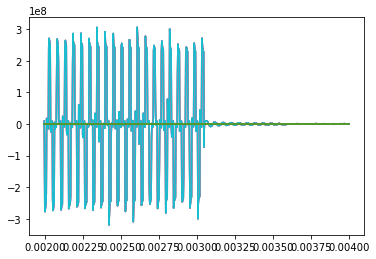

In [461]:
#Import flux data from 220816009
trajectory_list,inputs_list,state_deriv_list,experiment_time = load_shot('data/plasma_shots/flux_data/220816009',flux = True,plasma = True)
trajectory_list[0] = trajectory_list[0].T #flip dimsensions we always want states X snapshots
inputs_list[0] = inputs_list[0].T
#Grab points where time vector is > 0
time = experiment_time[experiment_time>0]
inputs_list[0] = inputs_list[0][:,experiment_time>0]
trajectory_list[0] = trajectory_list[0][:,experiment_time>0]
start = 1000
stop = 2005

train = trajectory_list[0][:,start:stop]-B_plasma@inputs_list[0][:,start:stop]
train_time = time[start:stop]
plt.plot(train_time,train.T)

99.99989726870992


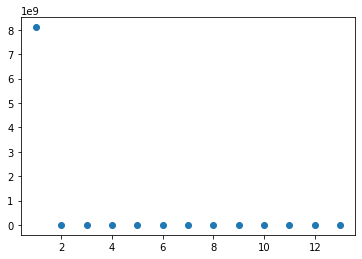

In [462]:
svdvals = scipy.linalg.svdvals(train)

plt.scatter(np.linspace(1,len(svdvals),len(svdvals)),svdvals ) #from this plot, Im gonna take between 5 and 7 values

print(np.sum(svdvals[0:7])/np.sum(svdvals)*100)

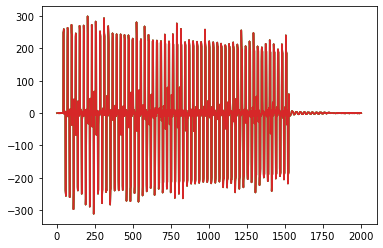

In [463]:
plt.plot(inputs_list[0].T)

(13, 1005)
(13, 1005)


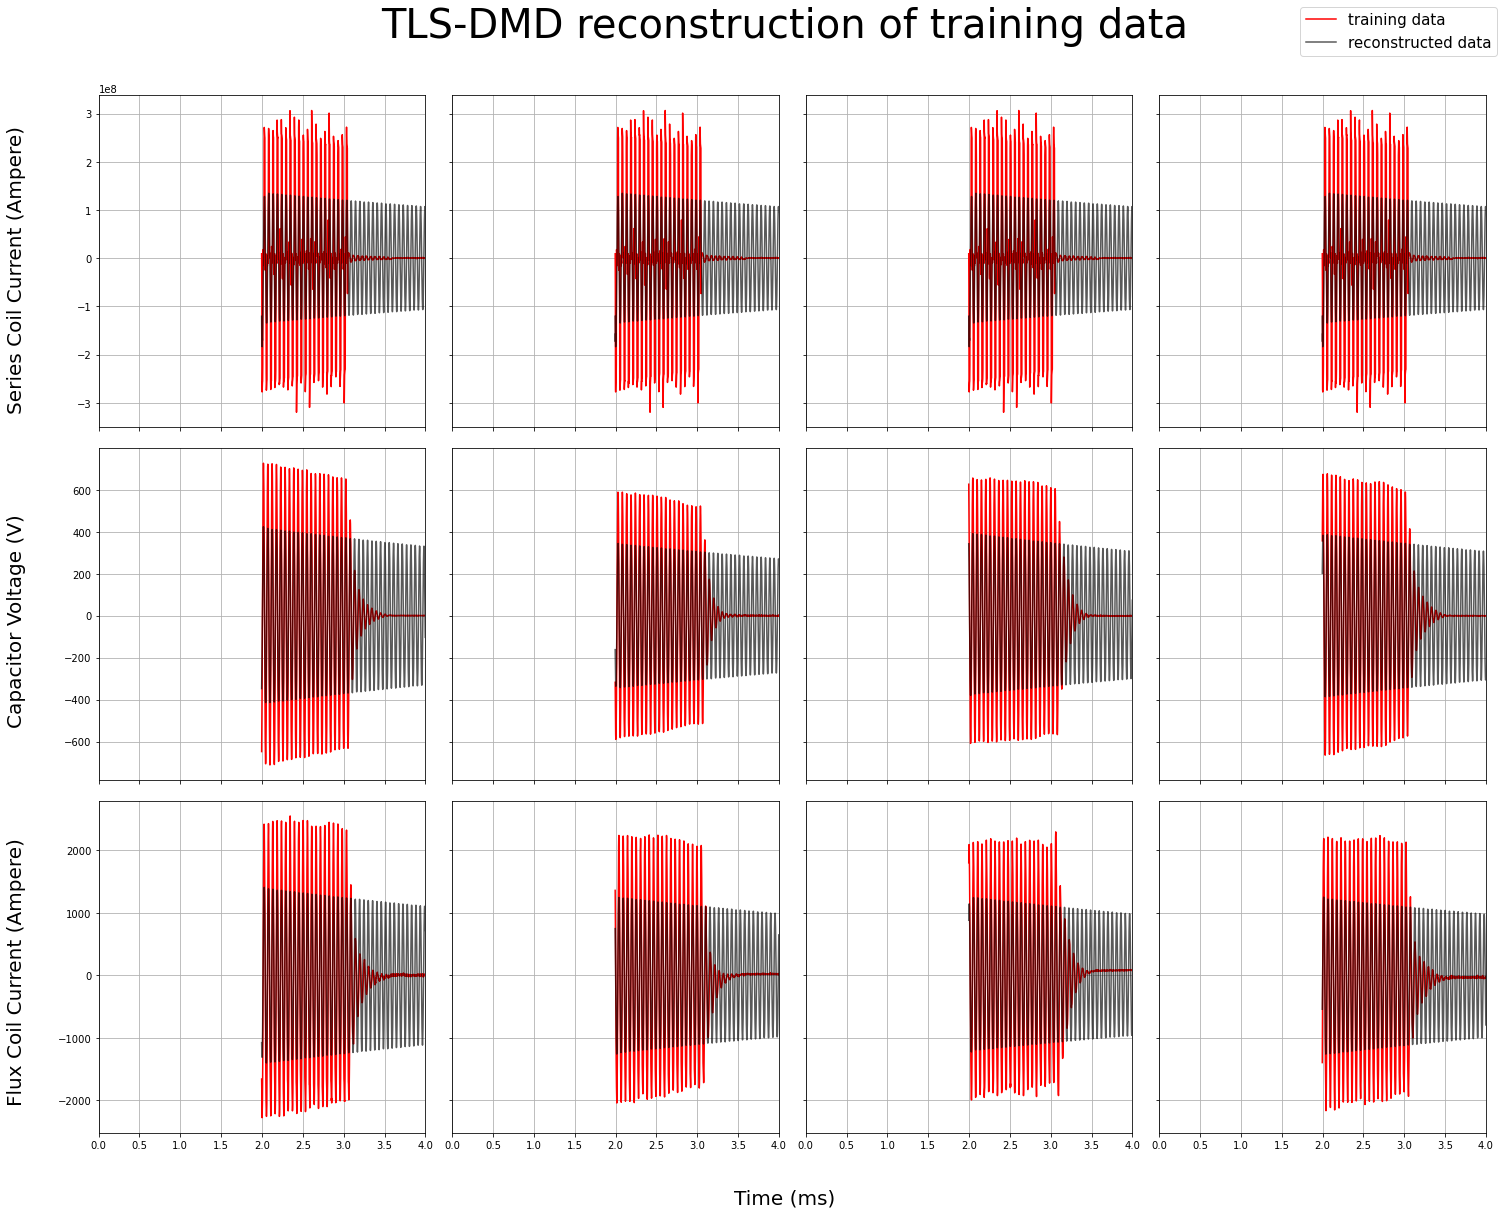

In [464]:
#create dmd object. We are going to be using the total least squares variant
r = 5
dmd = DMD(svd_rank = r,tlsq_rank = r, exact = False, opt = True)

#Fit the inputs subtracted off from the training data
dmd.fit(train)

A_tilde = dmd.operator._Atilde


recon_data = dmd.reconstructed_data
print(np.shape(train))
print(np.shape(recon_data))
make_graph([train.T,recon_data.T],'TLS-DMD reconstruction of training data',['training data','reconstructed data'],False,train_time)


In [465]:
modes = dmd.modes
A_dmd = modes@A_tilde@modes.T

print(np.linalg.eigvals(A_dmd))

[-2.76363406e+06+9.53501715e-08j -1.27861095e-07-1.50924061e-09j
 -8.75339168e-10-4.88275303e-11j  6.78187041e-10+3.90693636e-11j
 -2.77275149e-10+4.64548820e-12j  5.49216486e-11-3.45418287e-13j
  9.87995994e-12-3.00025994e-13j -6.66811526e-12+6.55683918e-14j
 -6.61537894e-18+4.16119022e-19j -3.47258774e-21-2.74397716e-22j
 -8.34535952e-22+8.37763309e-23j  3.05099164e-22+5.70605340e-23j
  6.45455136e-23+5.52250159e-25j]


In [468]:
#Cell for doing inverse 

discrete_time_top = np.hstack((A_dmd,B_d))
discrete_time_bottom = np.hstack( (np.eye(4), np.zeros((4,13)) ) )

discrete_time_matrix = np.vstack((discrete_time_top,discrete_time_bottom))

cont_time_matrix = scipy.linalg.logm(discrete_time_matrix)/dT

A_dmd_cont = cont_time_matrix[0:13,0:13]
print(np.linalg.eigvals(A_dmd_cont))
sysc_dmd = scipy.signal.StateSpace(A_dmd_cont,B_plasma,C_plasma,D)

t,y,xout_dmd = lsim(sysc_dmd,inputs_list[0].T,time)
xout_dmd = xout_dmd.T


logm result may be inaccurate, approximate err = 6.885474389497313e-12
[  7434611.34127442+1.57473237e+06j    168892.72888523-7.87366218e+05j
  -1888065.55958236+1.65044016e-02j   -920641.1776908 +7.87366184e+05j
    -66818.43958024+2.33385756e-02j  -7079060.00570261+1.48081712e+04j
  -8159242.16971066-1.44759240e+06j -11447541.20246824+1.46327916e+06j
 -14197173.36525708+1.57433492e+06j -17300540.24985167+7.53968628e+04j
 -18392429.6741349 -7.59967642e+04j -18684423.1505062 -1.56314733e+06j
 -17480506.59256894-1.57108851e+06j]


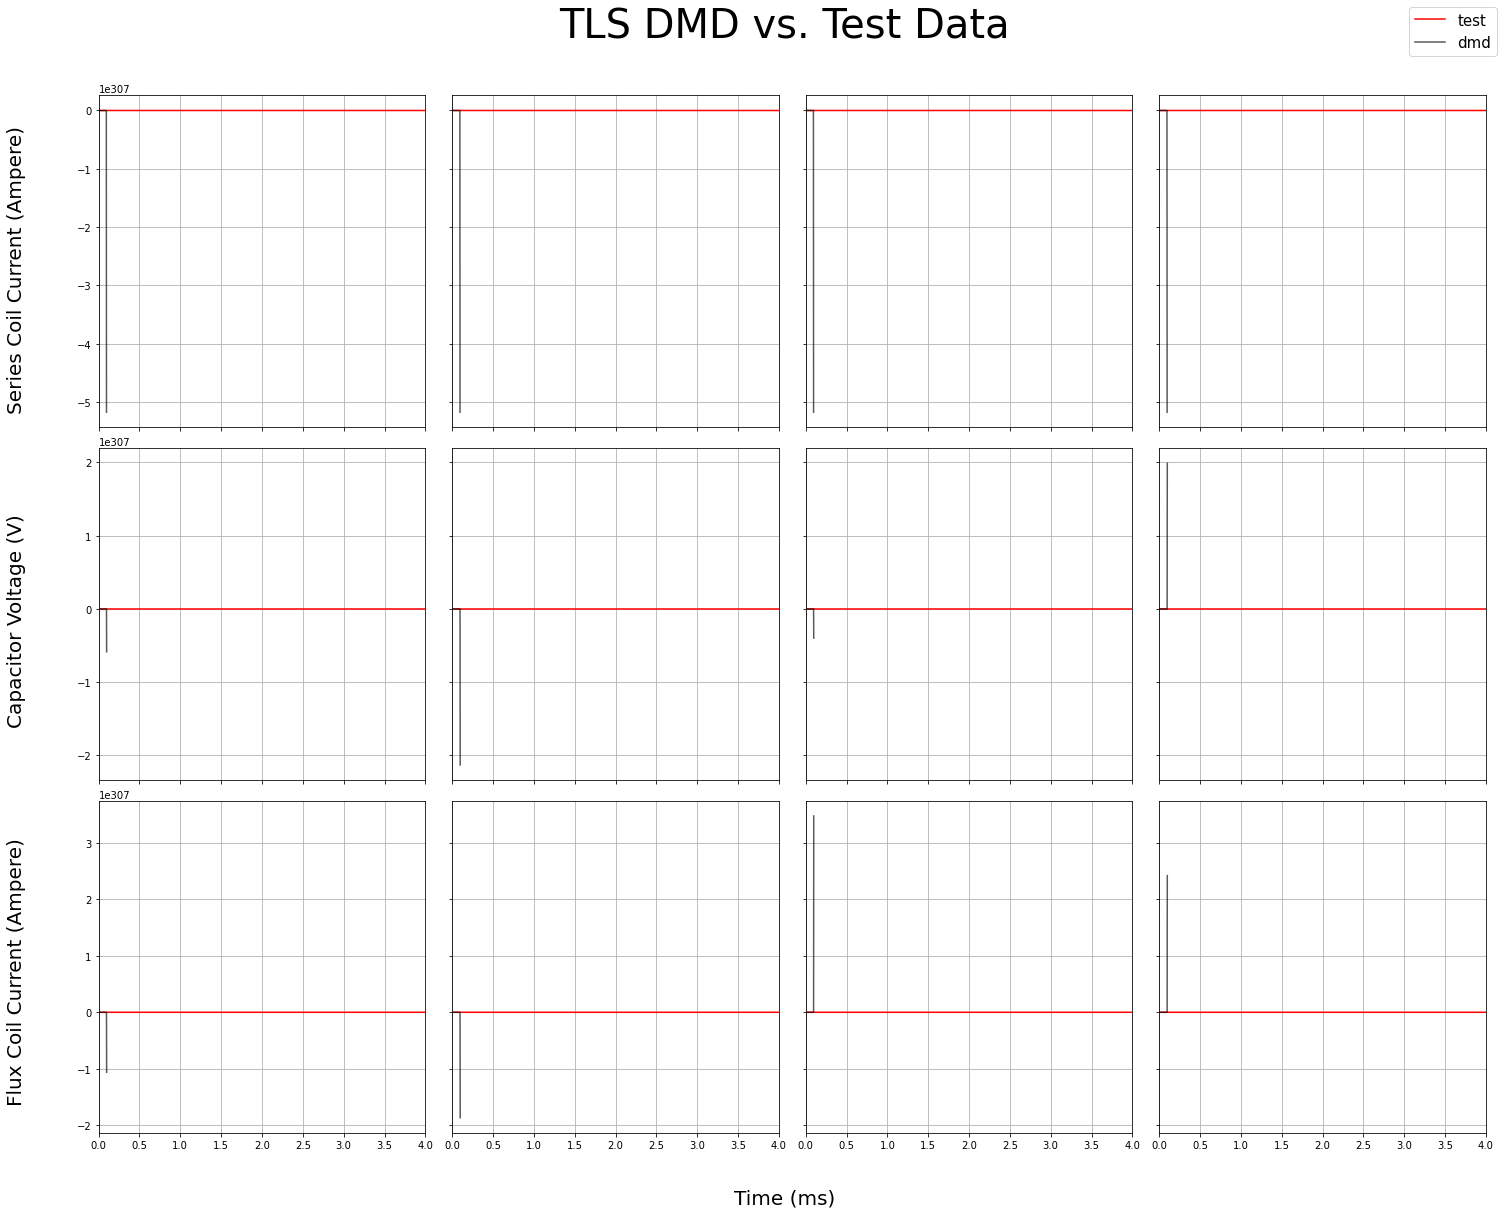

In [467]:
make_graph([trajectory_list[0].T,xout_dmd.T],'TLS DMD vs. Test Data',['test','dmd'],False,time)